In [ ]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 8396
-rw------- 1 root root 6428389 May 28 06:35 '03 Result Data Cleaning Part 3.csv'
-rw------- 1 root root 1171156 May 29 11:57  04a_ARIMA_Katulampa.ipynb
-rw------- 1 root root  250989 May 28 11:40  04c_ARIMA_Manggarai.ipynb
-rw------- 1 root root  708707 May 28 11:39  04e_ARIMA_Pasar_Ikan.ipynb
drwx------ 2 root root    4096 May 28 06:35  .git
-rw------- 1 root root   12122 May 28 09:14  LibrariesFunctions.py
-rw------- 1 root root    3166 May 28 11:56 'model_comparison_Katulampa (air)_results.csv'
-rw------- 1 root root    2636 May 28 11:40 'model_comparison_Manggarai (air)_results.csv'
-rw------- 1 root root    8442 May 28 22:40 'model_comparison_Pasar Ikan (air)_results.csv'
drwx------ 2 root root    4096 May 28 06:35  __pycache__
-rw------- 1 root root      11 May 28 06:35  README.md


In [ ]:
# Import libraries and functions
%run LibrariesFunctions.py
from LibrariesFunctions import *

# Import Data

In [ ]:
data_x_train, data_x_test, data_y_train, data_y_test = read_data('Katulampa')

Full Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31224 entries, 2021-10-16 00:00:00 to 2025-05-08 23:00:00
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_Raw                31196 non-null  float64
 1   ID_Cleaned            31224 non-null  int64  
 2   Katulampa (air)       31224 non-null  float64
 3   Katulampa (cuaca)     31224 non-null  object 
 4   Depok (air)           31224 non-null  float64
 5   Depok (cuaca)         31224 non-null  object 
 6   Manggarai (air)       31224 non-null  float64
 7   Manggarai (cuaca)     31224 non-null  object 
 8   Karet (air)           31224 non-null  float64
 9   Karet (cuaca)         31224 non-null  object 
 10  Krukut (air)          31224 non-null  float64
 11  Krukut (cuaca)        31224 non-null  object 
 12  Pesanggrahan (air)    31224 non-null  float64
 13  Pesanggrahan (cuaca)  31224 non-null  object 
 14  Angke (ai

In [ ]:
data_y_train

Tanggal
2021-10-16 00:00:00    10.0
2021-10-16 01:00:00    10.0
2021-10-16 02:00:00    10.0
2021-10-16 03:00:00    10.0
2021-10-16 04:00:00    10.0
                       ... 
2025-03-04 17:00:00    70.0
2025-03-04 18:00:00    70.0
2025-03-04 19:00:00    60.0
2025-03-04 20:00:00    60.0
2025-03-04 21:00:00    60.0
Name: Katulampa (air), Length: 29662, dtype: float64

# EDA

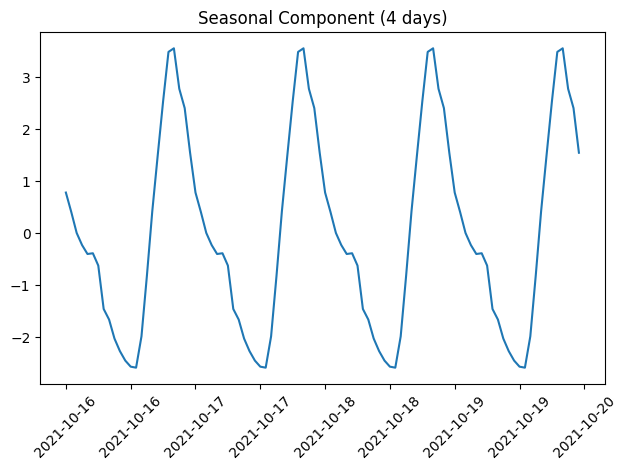

In [ ]:
period = 24

decomposition = seasonal_decompose(
    data_y_train,
    model='additive',
    period=period,
    extrapolate_trend='freq'
)
plot_decompose(decomposition)

# Uji Stasioneritas

## Uji Stasioneritas terhadap Varians

$$
\begin{aligned}
H_0&: \lambda=1 \text{(Stasioner terhadap varians)}\\H_1&: \lambda\ne1\\
\end{aligned}
$$

In [ ]:
lambda_opt = boxcox_transformation(data_y_train)

Lambda optimal: -1.3925
LRT statistic: 37668.5313
P-value: 0.000000


In [ ]:
print(f"{lambda_opt:.50f}")

-1.39248036591364821035199383914005011320114135742188


Karena P-Value LR test lambda(1) = 0.000000 < 0.05, maka tolak H0, maka data tidak stasioner terhadap varians, sehingga perlu dilakukan transformasi sesuai dengan lambda optimal

In [ ]:
data_y_train_pow = data_y_train ** lambda_opt
boxcox_transformation(data_y_train_pow)

Lambda optimal: 1.0000
LRT statistic: 0.0000
P-value: 0.999996


np.float64(0.9999999795043365)

## Uji Stasioneritas terhadap Mean

$$
\begin{aligned}
H_0&: \text{Data tidak stasioner terhadap mean}\\
H_1&: \text{Data stasioner terhadap mean}\\
\end{aligned}
$$

In [ ]:
result = adfuller(data_y_train_pow)

# Hasil ADF test
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {value}")

ADF Statistic : -8.098528274190905
p-value       : 1.3189154107984117e-12
Critical Values:
   1% : -3.4305708593757225
   5% : -2.86163761382706
   10% : -2.5668219568695214


# ACF PACF

Karena p-value 1.275e-18 =  < 0.05, maka tolak H0, sehingga kita memiliki cukup bukti untuk menyimpulkan bahwa data stasioner terhadap mean

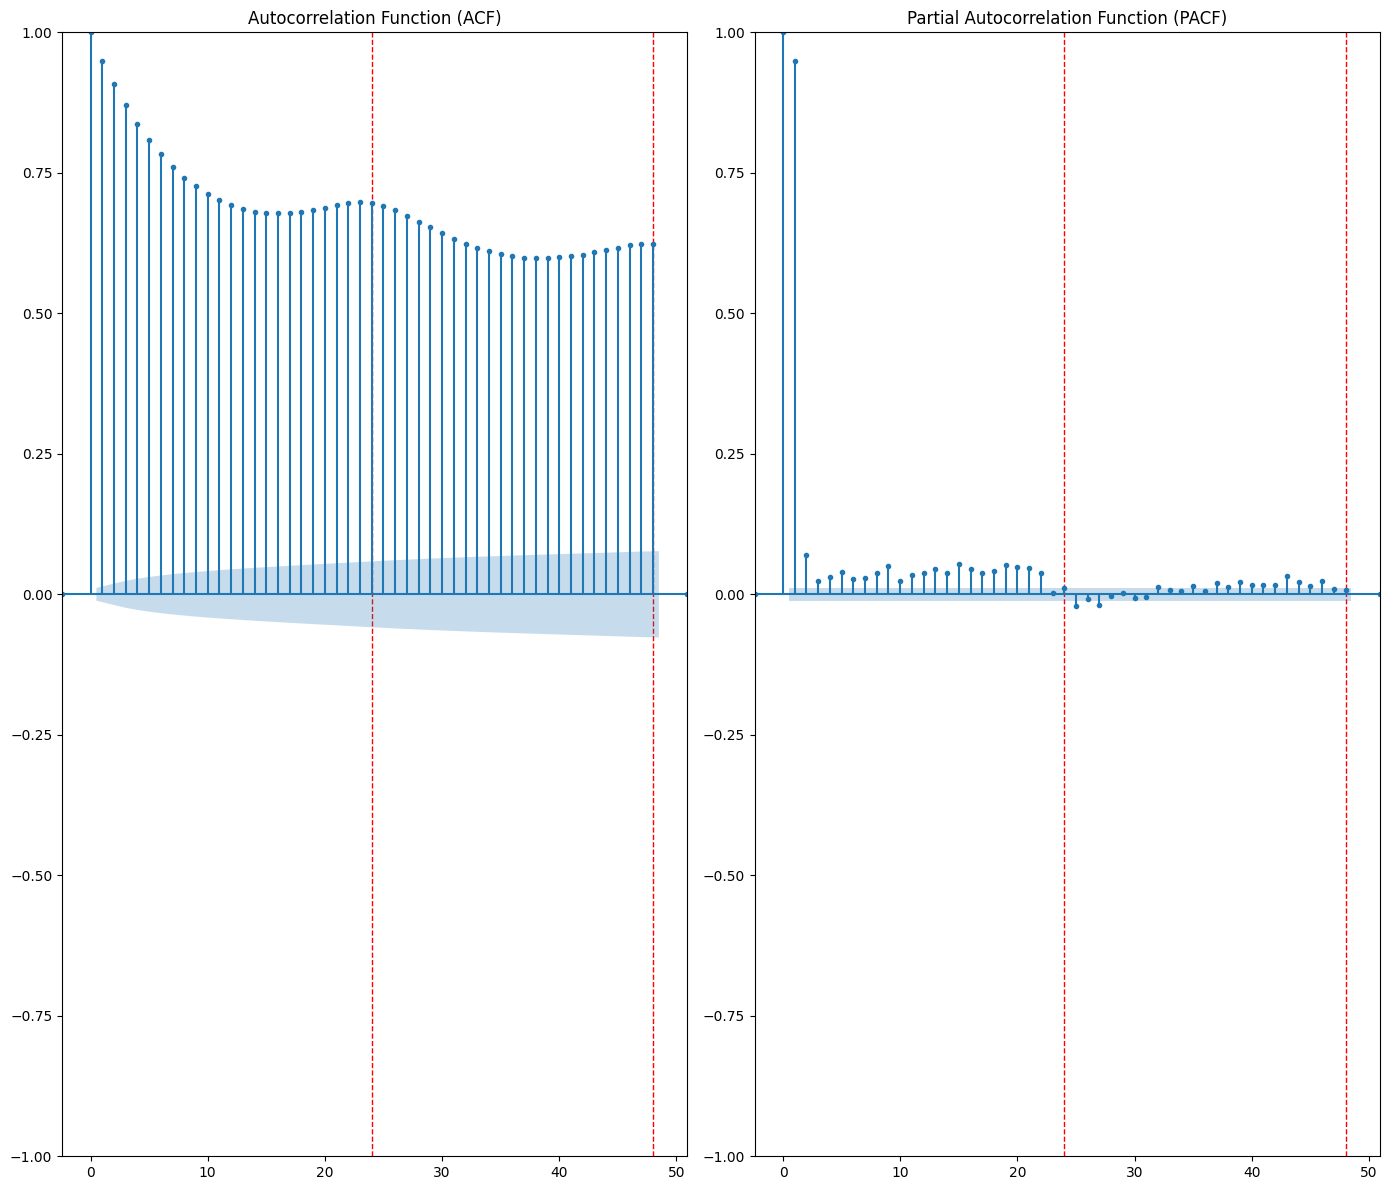

In [ ]:
plot_acf_pacf(data_y_train_pow, period, 48)

# Modelling

In [ ]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-22)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(8,0,0)', 'model_type': 'ARIMA', 'order': (8,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,0)', 'model_type': 'ARIMA', 'order': (9,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(10,0,0)', 'model_type': 'ARIMA', 'order': (10,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(11,0,0)', 'model_type': 'ARIMA', 'order': (11,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(12,0,0)', 'model_type': 'ARIMA', 'order': (12,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(13,0,0)', 'model_type': 'ARIMA', 'order': (13,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(14,0,0)', 'model_type': 'ARIMA', 'order': (14,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(15,0,0)', 'model_type': 'ARIMA', 'order': (15,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(16,0,0)', 'model_type': 'ARIMA', 'order': (16,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(17,0,0)', 'model_type': 'ARIMA', 'order': (17,0,0), 'seasonal_order': None, 'exog': False},
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood              117913.558
Date:                Wed, 28 May 2025   AIC                        -235821.117
Time:                        10:16:35   BIC                        -235796.224
Sample:                    10-16-2021   HQIC                       -235813.125
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.001     44.263      0.000       0.027       0.030
ar.L1          0.9495      0.005    175.635      0.000       0.93

Nama Dataset          Model Semua Variabel Signifikan  \
0   Katulampa (air)   ARIMA(1,0,0)                        Ya   
1   Katulampa (air)   ARIMA(2,0,0)                        Ya   
2   Katulampa (air)   ARIMA(3,0,0)                        Ya   
3   Katulampa (air)   ARIMA(4,0,0)                     Tidak   
4   Katulampa (air)   ARIMA(5,0,0)                     Tidak   
5   Katulampa (air)   ARIMA(6,0,0)                     Tidak   
6   Katulampa (air)   ARIMA(7,0,0)                     Tidak   
7   Katulampa (air)   ARIMA(8,0,0)                     Tidak   
8   Katulampa (air)   ARIMA(9,0,0)                     Tidak   
9   Katulampa (air)  ARIMA(10,0,0)                     Tidak   
10  Katulampa (air)  ARIMA(11,0,0)                     Tidak   
11  Katulampa (air)  ARIMA(12,0,0)                     Tidak   
12  Katulampa (air)  ARIMA(13,0,0)                     Tidak   
13  Katulampa (air)  ARIMA(14,0,0)                     Tidak   
14  Katulampa (air)  ARIMA(15,0,0)                     Tidak   
15  Katulampa (air)  ARIMA(16,0,0)                     Tidak   
16  Katulampa (air)  ARIMA(17,0,0)                     Tidak   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.005869        Tidak            0.001000              Tidak   
11          0.004452        Tidak            0.001000              Tidak   
12          0.003176        Tidak            0.001000              Tidak   
13          0.003648        Tidak            0.001000              Tidak   
14          0.009966        Tidak            0.001000              Tidak   
15          0.029515        Tidak            0.001000              Tidak   
16          0.089957           Ya            0.001000              Tidak   

   RMSE Training RMSE Testing  
0         6.0644      14.3387  
1         6.1930      14.2829  
2         6.2423      14.2621  
3         6.2769      14.2329  
4         6.2999      14.1918  
5         6.3147      14.1622  
6         6.3274      14.1278  
7         6.3390      14.0795  
8         6.3435      14.0096  
9         6.3416      13.9754  
10        6.3369      13.9206  
11        6.3274      13.8561  
12        6.3210      13.7742  
13        6.3212      13.6979  
14        6.2963      13.5804  
15        6.2802      13.4719  
16        6.2754      13.3763

In [ ]:
# Try MA models
ma_configs = [
    {'name': 'ARIMA(0,0,1)', 'model_type': 'ARIMA', 'order': (0,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,2)', 'model_type': 'ARIMA', 'order': (0,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,3)', 'model_type': 'ARIMA', 'order': (0,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,4)', 'model_type': 'ARIMA', 'order': (0,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,5)', 'model_type': 'ARIMA', 'order': (0,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,6)', 'model_type': 'ARIMA', 'order': (0,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,7)', 'model_type': 'ARIMA', 'order': (0,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,8)', 'model_type': 'ARIMA', 'order': (0,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,9)', 'model_type': 'ARIMA', 'order': (0,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,10)', 'model_type': 'ARIMA', 'order': (0,0,10), 'seasonal_order': None, 'exog': False},
]
ma_comparison = modelling (ma_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma_comparison


Testing ARIMA(0,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(0, 0, 1)   Log Likelihood               97668.228
Date:                Wed, 28 May 2025   AIC                        -195330.455
Time:                        10:33:45   BIC                        -195305.563
Sample:                    10-16-2021   HQIC                       -195322.464
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.000    268.433      0.000       0.028       0.029
ma.L1          0.7973      0.003    238.774      0.000       0.79

Nama Dataset          Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)   ARIMA(0,0,1)                        Ya          0.000000   
1  Katulampa (air)   ARIMA(0,0,2)                        Ya          0.000000   
2  Katulampa (air)   ARIMA(0,0,3)                        Ya          0.000000   
3  Katulampa (air)   ARIMA(0,0,4)                        Ya          0.000000   
4  Katulampa (air)   ARIMA(0,0,5)                        Ya          0.000000   
5  Katulampa (air)   ARIMA(0,0,6)                        Ya          0.000000   
6  Katulampa (air)   ARIMA(0,0,7)                        Ya          0.000000   
7  Katulampa (air)   ARIMA(0,0,8)                        Ya          0.000000   
8  Katulampa (air)   ARIMA(0,0,9)                        Ya          0.000000   
9  Katulampa (air)  ARIMA(0,0,10)                        Ya          0.000000   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak           nan   
1        Tidak            0.001000              Tidak           nan   
2        Tidak            0.001000              Tidak           nan   
3        Tidak            0.001000              Tidak           nan   
4        Tidak            0.001000              Tidak           nan   
5        Tidak            0.001000              Tidak           nan   
6        Tidak            0.001000              Tidak           nan   
7        Tidak            0.001000              Tidak           nan   
8        Tidak            0.001000              Tidak           nan   
9        Tidak            0.001000              Tidak           nan   

  RMSE Testing  
0      14.7161  
1      14.7038  
2      14.6936  
3      14.6804  
4      14.6745  
5      14.6658  
6      14.6566  
7      14.6498  
8      14.6391  
9      14.6115

In [ ]:
# Try MA models
ma2_configs = [
    {'name': 'ARIMA(0,0,11)', 'model_type': 'ARIMA', 'order': (0,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,12)', 'model_type': 'ARIMA', 'order': (0,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,13)', 'model_type': 'ARIMA', 'order': (0,0,13), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,14)', 'model_type': 'ARIMA', 'order': (0,0,14), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,15)', 'model_type': 'ARIMA', 'order': (0,0,15), 'seasonal_order': None, 'exog': False}
]
ma2_comparison = modelling (ma2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma2_comparison


Testing ARIMA(0,0,11)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 11)   Log Likelihood              116530.941
Date:                Wed, 28 May 2025   AIC                        -233035.882
Time:                        10:58:38   BIC                        -232928.012
Sample:                    10-16-2021   HQIC                       -233001.252
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.000    119.659      0.000       0.028       0.029
ma.L1          0.9606      0.004    262.047      0.000       0.9

Nama Dataset          Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMA(0,0,11)                        Ya          0.000000   
1  Katulampa (air)  ARIMA(0,0,12)                        Ya          0.000000   
2  Katulampa (air)  ARIMA(0,0,13)                        Ya          0.000000   
3  Katulampa (air)  ARIMA(0,0,14)                        Ya          0.000000   
4  Katulampa (air)  ARIMA(0,0,15)                        Ya          0.000000   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak           nan   
1        Tidak            0.001000              Tidak           nan   
2        Tidak            0.001000              Tidak           nan   
3        Tidak            0.001000              Tidak        8.6139   
4        Tidak            0.001000              Tidak        7.2263   

  RMSE Testing  
0      14.6175  
1      14.6178  
2      14.6085  
3      14.6011  
4      14.6014

In [ ]:
# Try MA models
ma3_configs = [
    {'name': 'ARIMA(0,0,16)', 'model_type': 'ARIMA', 'order': (0,0,16), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,17)', 'model_type': 'ARIMA', 'order': (0,0,17), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,18)', 'model_type': 'ARIMA', 'order': (0,0,18), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,19)', 'model_type': 'ARIMA', 'order': (0,0,19), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,20)', 'model_type': 'ARIMA', 'order': (0,0,20), 'seasonal_order': None, 'exog': False},
]
ma3_comparison = modelling (ma3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma3_comparison


Testing ARIMA(0,0,16)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 16)   Log Likelihood              117224.796
Date:                Wed, 28 May 2025   AIC                        -234413.591
Time:                        11:22:44   BIC                        -234264.234
Sample:                    10-16-2021   HQIC                       -234365.642
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0286      0.000     97.779      0.000       0.028       0.029
ma.L1          0.9256      0.004    256.221      0.000       0.9

Nama Dataset          Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMA(0,0,16)                        Ya          0.000000   
1  Katulampa (air)  ARIMA(0,0,17)                        Ya          0.000000   
2  Katulampa (air)  ARIMA(0,0,18)                        Ya          0.000000   
3  Katulampa (air)  ARIMA(0,0,19)                        Ya          0.000000   
4  Katulampa (air)  ARIMA(0,0,20)                        Ya          0.000000   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak        6.8257   
1        Tidak            0.001000              Tidak        6.7751   
2        Tidak            0.001000              Tidak        6.6462   
3        Tidak            0.001000              Tidak        6.6099   
4        Tidak            0.001000              Tidak        6.5727   

  RMSE Testing  
0      14.6308  
1      14.5768  
2      14.5698  
3      14.5615  
4      14.5613

In [ ]:
compare = pd.concat([ar_comparison,
                     ma_comparison,
                     ma2_comparison,
                     ma3_comparison
                     ])
compare.to_csv(f'model_comparison_{data_y_train.name}_results.csv')

In [ ]:
compare = pd.read_csv(f'model_comparison_{data_y_train.name}_results.csv', index_col=0)
compare

Nama Dataset          Model Semua Variabel Signifikan  \
0   Katulampa (air)   ARIMA(1,0,0)                        Ya   
1   Katulampa (air)   ARIMA(2,0,0)                        Ya   
2   Katulampa (air)   ARIMA(3,0,0)                        Ya   
3   Katulampa (air)   ARIMA(4,0,0)                     Tidak   
4   Katulampa (air)   ARIMA(5,0,0)                     Tidak   
5   Katulampa (air)   ARIMA(6,0,0)                     Tidak   
6   Katulampa (air)   ARIMA(7,0,0)                     Tidak   
7   Katulampa (air)   ARIMA(8,0,0)                     Tidak   
8   Katulampa (air)   ARIMA(9,0,0)                     Tidak   
9   Katulampa (air)  ARIMA(10,0,0)                     Tidak   
10  Katulampa (air)  ARIMA(11,0,0)                     Tidak   
11  Katulampa (air)  ARIMA(12,0,0)                     Tidak   
12  Katulampa (air)  ARIMA(13,0,0)                     Tidak   
13  Katulampa (air)  ARIMA(14,0,0)                     Tidak   
14  Katulampa (air)  ARIMA(15,0,0)                     Tidak   
15  Katulampa (air)  ARIMA(16,0,0)                     Tidak   
16  Katulampa (air)  ARIMA(17,0,0)                     Tidak   
0   Katulampa (air)   ARIMA(0,0,1)                        Ya   
1   Katulampa (air)   ARIMA(0,0,2)                        Ya   
2   Katulampa (air)   ARIMA(0,0,3)                        Ya   
3   Katulampa (air)   ARIMA(0,0,4)                        Ya   
4   Katulampa (air)   ARIMA(0,0,5)                        Ya   
5   Katulampa (air)   ARIMA(0,0,6)                        Ya   
6   Katulampa (air)   ARIMA(0,0,7)                        Ya   
7   Katulampa (air)   ARIMA(0,0,8)                        Ya   
8   Katulampa (air)   ARIMA(0,0,9)                        Ya   
9   Katulampa (air)  ARIMA(0,0,10)                        Ya   
0   Katulampa (air)  ARIMA(0,0,11)                        Ya   
1   Katulampa (air)  ARIMA(0,0,12)                        Ya   
2   Katulampa (air)  ARIMA(0,0,13)                        Ya   
3   Katulampa (air)  ARIMA(0,0,14)                        Ya   
4   Katulampa (air)  ARIMA(0,0,15)                        Ya   
0   Katulampa (air)  ARIMA(0,0,16)                        Ya   
1   Katulampa (air)  ARIMA(0,0,17)                        Ya   
2   Katulampa (air)  ARIMA(0,0,18)                        Ya   
3   Katulampa (air)  ARIMA(0,0,19)                        Ya   
4   Katulampa (air)  ARIMA(0,0,20)                        Ya   

    P-value Ljung Box White Noise?  P-value Lillie Test Distribusi Normal?  \
0            0.000000        Tidak                0.001              Tidak   
1            0.000000        Tidak                0.001              Tidak   
2            0.000000        Tidak                0.001              Tidak   
3            0.000000        Tidak                0.001              Tidak   
4            0.000000        Tidak                0.001              Tidak   
5            0.000000        Tidak                0.001              Tidak   
6            0.000000        Tidak                0.001              Tidak   
7            0.000000        Tidak                0.001              Tidak   
8            0.000000        Tidak                0.001              Tidak   
9            0.000000        Tidak                0.001              Tidak   
10           0.005869        Tidak                0.001              Tidak   
11           0.004452        Tidak                0.001              Tidak   
12           0.003176        Tidak                0.001              Tidak   
13           0.003648        Tidak                0.001              Tidak   
14           0.009966        Tidak                0.001              Tidak   
15           0.029515        Tidak                0.001              Tidak   
16           0.089957           Ya                0.001              Tidak   
0            0.000000        Tidak                0.001              Tidak   
1            0.000000        Tidak                0.001              Tidak   
2            0

In [ ]:
# Try MA models
ma4_configs = [
    {'name': 'ARIMA(0,0,21)', 'model_type': 'ARIMA', 'order': (0,0,21), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,22)', 'model_type': 'ARIMA', 'order': (0,0,22), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,23)', 'model_type': 'ARIMA', 'order': (0,0,23), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,24)', 'model_type': 'ARIMA', 'order': (0,0,24), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,25)', 'model_type': 'ARIMA', 'order': (0,0,25), 'seasonal_order': None, 'exog': False}
]
ma4_comparison = modelling (ma4_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma4_comparison


Testing ARIMA(0,0,21)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 21)   Log Likelihood              117519.091
Date:                Wed, 28 May 2025   AIC                        -234992.182
Time:                        23:59:25   BIC                        -234801.337
Sample:                    10-16-2021   HQIC                       -234930.914
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.000     82.286      0.000       0.028       0.029
ma.L1          0.9084      0.004    248.090      0.000       0.9

Nama Dataset          Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMA(0,0,21)                        Ya          0.000000   
1  Katulampa (air)  ARIMA(0,0,22)                        Ya          0.000014   
2  Katulampa (air)  ARIMA(0,0,23)                        Ya          0.000057   
3  Katulampa (air)  ARIMA(0,0,24)                        Ya          0.000037   
4  Katulampa (air)  ARIMA(0,0,25)                        Ya          0.000626   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak        6.5615   
1        Tidak            0.001000              Tidak        6.5101   
2        Tidak            0.001000              Tidak        6.5027   
3        Tidak            0.001000              Tidak        6.4932   
4        Tidak            0.001000              Tidak        6.5010   

  RMSE Testing  
0      14.5626  
1      14.5490  
2      14.5467  
3      14.5449  
4      14.5430

In [ ]:
# Try MA models
ma5_configs = [
    {'name': 'ARIMA(0,0,26)', 'model_type': 'ARIMA', 'order': (0,0,26), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,27)', 'model_type': 'ARIMA', 'order': (0,0,27), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,28)', 'model_type': 'ARIMA', 'order': (0,0,28), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,29)', 'model_type': 'ARIMA', 'order': (0,0,29), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,30)', 'model_type': 'ARIMA', 'order': (0,0,30), 'seasonal_order': None, 'exog': False}
]
ma5_comparison = modelling (ma5_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma5_comparison


Testing ARIMA(0,0,26)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 26)   Log Likelihood              117595.700
Date:                Thu, 29 May 2025   AIC                        -235135.400
Time:                        01:21:37   BIC                        -234903.067
Sample:                    10-16-2021   HQIC                       -235060.813
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.000     78.548      0.000       0.028       0.029
ma.L1          0.9101      0.004    216.643      0.000       0.9

Nama Dataset          Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMA(0,0,26)                        Ya          0.000000   
1  Katulampa (air)  ARIMA(0,0,27)                        Ya          0.000000   
2  Katulampa (air)  ARIMA(0,0,28)                        Ya          0.000000   
3  Katulampa (air)  ARIMA(0,0,29)                        Ya          0.000000   
4  Katulampa (air)  ARIMA(0,0,30)                        Ya          0.000000   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak        6.5418   
1        Tidak            0.001000              Tidak        6.6119   
2        Tidak            0.001000              Tidak        6.6513   
3        Tidak            0.001000              Tidak        6.6534   
4        Tidak            0.001000              Tidak        6.6779   

  RMSE Testing  
0      14.5338  
1      14.5300  
2      14.5179  
3      14.4983  
4      14.5051

In [ ]:
# Try ARMA models
arma_configs = [
    {'name': 'ARIMA(1,0,1)', 'model_type': 'ARIMA', 'order': (1,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,2)', 'model_type': 'ARIMA', 'order': (1,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,3)', 'model_type': 'ARIMA', 'order': (1,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,4)', 'model_type': 'ARIMA', 'order': (1,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,5)', 'model_type': 'ARIMA', 'order': (1,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,6)', 'model_type': 'ARIMA', 'order': (1,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,7)', 'model_type': 'ARIMA', 'order': (1,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,8)', 'model_type': 'ARIMA', 'order': (1,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,9)', 'model_type': 'ARIMA', 'order': (1,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,10)', 'model_type': 'ARIMA', 'order': (1,0,10), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,11)', 'model_type': 'ARIMA', 'order': (1,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,12)', 'model_type': 'ARIMA', 'order': (1,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,13)', 'model_type': 'ARIMA', 'order': (1,0,13), 'seasonal_order': None, 'exog': False},
]
arma_comparison = modelling (arma_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma_comparison


Testing ARIMA(1,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 1)   Log Likelihood              117990.546
Date:                Thu, 29 May 2025   AIC                        -235973.091
Time:                        02:55:42   BIC                        -235939.901
Sample:                    10-16-2021   HQIC                       -235962.436
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.001     41.208      0.000       0.027       0.030
ar.L1          0.9569      0.005    190.805      0.000       0.94

Nama Dataset          Model Semua Variabel Signifikan  \
0   Katulampa (air)   ARIMA(1,0,1)                        Ya   
1   Katulampa (air)   ARIMA(1,0,2)                        Ya   
2   Katulampa (air)   ARIMA(1,0,3)                        Ya   
3   Katulampa (air)   ARIMA(1,0,4)                        Ya   
4   Katulampa (air)   ARIMA(1,0,5)                        Ya   
5   Katulampa (air)   ARIMA(1,0,6)                        Ya   
6   Katulampa (air)   ARIMA(1,0,7)                        Ya   
7   Katulampa (air)   ARIMA(1,0,8)                        Ya   
8   Katulampa (air)   ARIMA(1,0,9)                        Ya   
9   Katulampa (air)  ARIMA(1,0,10)                        Ya   
10  Katulampa (air)  ARIMA(1,0,11)                        Ya   
11  Katulampa (air)  ARIMA(1,0,12)                        Ya   
12  Katulampa (air)  ARIMA(1,0,13)                        Ya   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000001        Tidak            0.001000              Tidak   
9           0.778895           Ya            0.001000              Tidak   
10          0.728794           Ya            0.001000              Tidak   
11          0.736354           Ya            0.001000              Tidak   
12          0.829196           Ya            0.001000              Tidak   

   RMSE Training RMSE Testing  
0         6.2062      14.2767  
1         6.2580      14.2520  
2         6.3046      14.2066  
3         6.3426      14.1319  
4         6.3689      14.0563  
5         6.3904      13.9240  
6         6.4062      13.6705  
7         6.3712      13.0602  
8         6.3283      12.8033  
9         6.3786      12.6261  
10        6.3754      12.8905  
11        6.3632      12.7475  
12        6.3597      12.4522

In [ ]:
# Try ARMA models
arma2_configs = [
    {'name': 'ARIMA(1,0,15)', 'model_type': 'ARIMA', 'order': (1,0,15), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,16)', 'model_type': 'ARIMA', 'order': (1,0,16), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,17)', 'model_type': 'ARIMA', 'order': (1,0,17), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,18)', 'model_type': 'ARIMA', 'order': (1,0,18), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,19)', 'model_type': 'ARIMA', 'order': (1,0,19), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,20)', 'model_type': 'ARIMA', 'order': (1,0,20), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,21)', 'model_type': 'ARIMA', 'order': (1,0,21), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,22)', 'model_type': 'ARIMA', 'order': (1,0,22), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,23)', 'model_type': 'ARIMA', 'order': (1,0,23), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(1,0,24)', 'model_type': 'ARIMA', 'order': (1,0,24), 'seasonal_order': None, 'exog': False}
]
arma2_comparison = modelling (arma2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma2_comparison


Testing ARIMA(1,0,15)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                ARIMA(1, 0, 15)   Log Likelihood              118404.778
Date:                Thu, 29 May 2025   AIC                        -236773.557
Time:                        03:15:47   BIC                        -236624.200
Sample:                    10-16-2021   HQIC                       -236725.608
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.002     15.991      0.000       0.025       0.032
ar.L1          0.9954      0.001    779.107      0.000       0.9

Nama Dataset          Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMA(1,0,15)                        Ya          0.895833   
1  Katulampa (air)  ARIMA(1,0,16)                     Tidak          0.925691   
2  Katulampa (air)  ARIMA(1,0,17)                     Tidak          0.966286   
3  Katulampa (air)  ARIMA(1,0,18)                     Tidak          0.989326   
4  Katulampa (air)  ARIMA(1,0,19)                     Tidak          0.993781   
5  Katulampa (air)  ARIMA(1,0,20)                     Tidak          0.980852   
6  Katulampa (air)  ARIMA(1,0,21)                     Tidak          0.965144   
7  Katulampa (air)  ARIMA(1,0,22)                     Tidak          0.972067   
8  Katulampa (air)  ARIMA(1,0,23)                     Tidak          0.981570   
9  Katulampa (air)  ARIMA(1,0,24)                     Tidak          0.990858   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0           Ya            0.001000              Tidak        6.3406   
1           Ya            0.001000              Tidak        6.3387   
2           Ya            0.001000              Tidak        6.3378   
3           Ya            0.001000              Tidak        6.3417   
4           Ya            0.001000              Tidak        6.3477   
5           Ya            0.001000              Tidak        6.3549   
6           Ya            0.001000              Tidak        6.3559   
7           Ya            0.001000              Tidak        6.3412   
8           Ya            0.001000              Tidak        6.3368   
9           Ya            0.001000              Tidak        6.3265   

  RMSE Testing  
0      11.9028  
1      11.7801  
2      11.5549  
3      11.0895  
4      10.5765  
5      10.2817  
6      10.5268  
7      11.5914  
8      12.1156  
9      12.6074

In [ ]:
# Try ARMA models
arma3_configs = [
    {'name': 'ARIMA(2,0,1)', 'model_type': 'ARIMA', 'order': (2,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,2)', 'model_type': 'ARIMA', 'order': (2,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,3)', 'model_type': 'ARIMA', 'order': (2,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,4)', 'model_type': 'ARIMA', 'order': (2,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,5)', 'model_type': 'ARIMA', 'order': (2,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,6)', 'model_type': 'ARIMA', 'order': (2,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,7)', 'model_type': 'ARIMA', 'order': (2,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,8)', 'model_type': 'ARIMA', 'order': (2,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,9)', 'model_type': 'ARIMA', 'order': (2,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,10)', 'model_type': 'ARIMA', 'order': (2,0,10), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,11)', 'model_type': 'ARIMA', 'order': (2,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,12)', 'model_type': 'ARIMA', 'order': (2,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,13)', 'model_type': 'ARIMA', 'order': (2,0,13), 'seasonal_order': None, 'exog': False},
]
arma3_comparison = modelling (arma3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma3_comparison


Testing ARIMA(2,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(2, 0, 1)   Log Likelihood              118006.259
Date:                Thu, 29 May 2025   AIC                        -236002.518
Time:                        03:56:08   BIC                        -235961.030
Sample:                    10-16-2021   HQIC                       -235989.199
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.001     39.972      0.000       0.027       0.030
ar.L1          1.2232      0.050     24.269      0.000       1.12

Nama Dataset          Model Semua Variabel Signifikan  \
0   Katulampa (air)   ARIMA(2,0,1)                        Ya   
1   Katulampa (air)   ARIMA(2,0,2)                        Ya   
2   Katulampa (air)   ARIMA(2,0,3)                        Ya   
3   Katulampa (air)   ARIMA(2,0,4)                        Ya   
4   Katulampa (air)   ARIMA(2,0,5)                     Tidak   
5   Katulampa (air)   ARIMA(2,0,6)                     Tidak   
6   Katulampa (air)   ARIMA(2,0,7)                     Tidak   
7   Katulampa (air)   ARIMA(2,0,8)                        Ya   
8   Katulampa (air)   ARIMA(2,0,9)                        Ya   
9   Katulampa (air)  ARIMA(2,0,10)                        Ya   
10  Katulampa (air)  ARIMA(2,0,11)                     Tidak   
11  Katulampa (air)  ARIMA(2,0,12)                     Tidak   
12  Katulampa (air)  ARIMA(2,0,13)                     Tidak   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.002082        Tidak            0.001000              Tidak   
7           0.001293        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.014461        Tidak            0.001000              Tidak   
11          0.000891        Tidak            0.001000              Tidak   
12          0.562691           Ya            0.001000              Tidak   

   RMSE Training RMSE Testing  
0         6.2492      14.2505  
1         6.0196      32.7518  
2         6.2379      13.8058  
3         6.0910      16.6730  
4         6.3130      13.7358  
5         6.2706      13.0121  
6         6.2294      10.6432  
7         6.2845      11.1327  
8         6.4343      14.4959  
9            nan        Error  
10        6.6319      13.8649  
11        6.6377      13.9875  
12        6.4915      13.3864

In [ ]:
arma4_configs = [
    {'name': 'ARIMA(3,0,1)', 'model_type': 'ARIMA', 'order': (3,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,2)', 'model_type': 'ARIMA', 'order': (3,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,3)', 'model_type': 'ARIMA', 'order': (3,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,4)', 'model_type': 'ARIMA', 'order': (3,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,5)', 'model_type': 'ARIMA', 'order': (3,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,6)', 'model_type': 'ARIMA', 'order': (3,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,7)', 'model_type': 'ARIMA', 'order': (3,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,8)', 'model_type': 'ARIMA', 'order': (3,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,9)', 'model_type': 'ARIMA', 'order': (3,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,10)', 'model_type': 'ARIMA', 'order': (3,0,10), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,11)', 'model_type': 'ARIMA', 'order': (3,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,12)', 'model_type': 'ARIMA', 'order': (3,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,13)', 'model_type': 'ARIMA', 'order': (3,0,13), 'seasonal_order': None, 'exog': False},
]
arma4_comparison = modelling (arma4_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma4_comparison


Testing ARIMA(3,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(3, 0, 1)   Log Likelihood              117990.034
Date:                Thu, 29 May 2025   AIC                        -235968.068
Time:                        04:29:38   BIC                        -235918.282
Sample:                    10-16-2021   HQIC                       -235952.085
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.001     40.766      0.000       0.027       0.030
ar.L1          0.5809      0.156      3.731      0.000       0.27

Nama Dataset          Model Semua Variabel Signifikan  \
0   Katulampa (air)   ARIMA(3,0,1)                     Tidak   
1   Katulampa (air)   ARIMA(3,0,2)                     Tidak   
2   Katulampa (air)   ARIMA(3,0,3)                     Tidak   
3   Katulampa (air)   ARIMA(3,0,4)                     Tidak   
4   Katulampa (air)   ARIMA(3,0,5)                     Tidak   
5   Katulampa (air)   ARIMA(3,0,6)                        Ya   
6   Katulampa (air)   ARIMA(3,0,7)                     Tidak   
7   Katulampa (air)   ARIMA(3,0,8)                     Tidak   
8   Katulampa (air)   ARIMA(3,0,9)                     Tidak   
9   Katulampa (air)  ARIMA(3,0,10)                     Tidak   
10  Katulampa (air)  ARIMA(3,0,11)                     Tidak   
11  Katulampa (air)  ARIMA(3,0,12)                     Tidak   
12  Katulampa (air)  ARIMA(3,0,13)                     Tidak   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.000000        Tidak            0.001000              Tidak   
11          0.000000        Tidak            0.001000              Tidak   
12          0.002712        Tidak            0.001000              Tidak   

   RMSE Training RMSE Testing  
0         6.2383      14.2671  
1         6.1519      14.3204  
2         6.2025      14.3313  
3            nan      14.6682  
4         6.1866      12.5508  
5            nan      24.2403  
6            nan        Error  
7            nan      14.4427  
8            nan      16.8949  
9            nan      14.6369  
10        6.8252      14.1856  
11        6.8394      14.3047  
12        6.6892      13.8832

In [ ]:
arma5_configs = [
    {'name': 'ARIMA(4,0,1)', 'model_type': 'ARIMA', 'order': (4,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,2)', 'model_type': 'ARIMA', 'order': (4,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,3)', 'model_type': 'ARIMA', 'order': (4,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,4)', 'model_type': 'ARIMA', 'order': (4,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,5)', 'model_type': 'ARIMA', 'order': (4,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,6)', 'model_type': 'ARIMA', 'order': (4,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,7)', 'model_type': 'ARIMA', 'order': (4,0,7), 'seasonal_order': None, 'exog': False}
]
arma5_comparison = modelling (arma5_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma5_comparison


Testing ARIMA(4,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(4, 0, 1)   Log Likelihood              117830.055
Date:                Thu, 29 May 2025   AIC                        -235646.111
Time:                        05:07:02   BIC                        -235588.027
Sample:                    10-16-2021   HQIC                       -235627.464
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0274      0.001     51.967      0.000       0.026       0.028
ar.L1          0.2626      0.030      8.622      0.000       0.20

Nama Dataset         Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMA(4,0,1)                        Ya          0.000000   
1  Katulampa (air)  ARIMA(4,0,2)                     Tidak          0.000000   
2  Katulampa (air)  ARIMA(4,0,3)                        Ya          0.000000   
3  Katulampa (air)  ARIMA(4,0,4)                     Tidak          0.000000   
4  Katulampa (air)  ARIMA(4,0,5)                     Tidak          0.000000   
5  Katulampa (air)  ARIMA(4,0,6)                     Tidak          0.000000   
6  Katulampa (air)  ARIMA(4,0,7)                     Tidak          0.000000   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak        6.3816   
1        Tidak            0.001000              Tidak        6.2190   
2        Tidak            0.001000              Tidak        6.4124   
3        Tidak            0.001000              Tidak        6.3567   
4        Tidak            0.001000              Tidak           nan   
5        Tidak            0.001000              Tidak           nan   
6        Tidak            0.001000              Tidak           nan   

  RMSE Testing  
0      14.1031  
1      14.3045  
2      12.5710  
3      14.6829  
4      14.4989  
5      14.7152  
6      14.4376

In [ ]:
arma6_configs = [
    {'name': 'ARIMA(5,0,1)', 'model_type': 'ARIMA', 'order': (5,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,2)', 'model_type': 'ARIMA', 'order': (5,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,3)', 'model_type': 'ARIMA', 'order': (5,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,4)', 'model_type': 'ARIMA', 'order': (5,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,5)', 'model_type': 'ARIMA', 'order': (5,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,6)', 'model_type': 'ARIMA', 'order': (5,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,7)', 'model_type': 'ARIMA', 'order': (5,0,7), 'seasonal_order': None, 'exog': False}
]
arma6_comparison = modelling (arma6_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arma6_comparison


Testing ARIMA(5,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(5, 0, 1)   Log Likelihood              118024.571
Date:                Thu, 29 May 2025   AIC                        -236033.141
Time:                        05:25:45   BIC                        -235966.761
Sample:                    10-16-2021   HQIC                       -236011.831
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.001     38.374      0.000       0.027       0.030
ar.L1          0.5784      0.117      4.955      0.000       0.35

Nama Dataset         Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMA(5,0,1)                     Tidak          0.000000   
1  Katulampa (air)  ARIMA(5,0,2)                     Tidak          0.000000   
2  Katulampa (air)  ARIMA(5,0,3)                     Tidak          0.000000   
3  Katulampa (air)  ARIMA(5,0,4)                     Tidak          0.000000   
4  Katulampa (air)  ARIMA(5,0,5)                     Tidak          0.000000   
5  Katulampa (air)  ARIMA(5,0,6)                     Tidak          0.000000   
6  Katulampa (air)  ARIMA(5,0,7)                     Tidak          0.000000   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak        6.2843   
1        Tidak            0.001000              Tidak        6.1609   
2        Tidak            0.001000              Tidak        6.1918   
3        Tidak            0.001000              Tidak        6.4739   
4        Tidak            0.001000              Tidak        6.2367   
5        Tidak            0.001000              Tidak        6.5099   
6        Tidak            0.001000              Tidak        6.7974   

  RMSE Testing  
0      14.2146  
1      13.4039  
2      14.1858  
3      13.8165  
4      13.9137  
5      14.5774  
6      13.7565

In [ ]:
# Try ARX and MAX models
arxmax_configs = [
    {'name': 'ARIMAX(1,0,0)', 'model_type': 'ARIMAX', 'order': (1,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,0)', 'model_type': 'ARIMAX', 'order': (2,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(3,0,0)', 'model_type': 'ARIMAX', 'order': (3,0,0), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,1)', 'model_type': 'ARIMAX', 'order': (0,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,2)', 'model_type': 'ARIMAX', 'order': (0,0,2), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,3)', 'model_type': 'ARIMAX', 'order': (0,0,3), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,4)', 'model_type': 'ARIMAX', 'order': (0,0,4), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,5)', 'model_type': 'ARIMAX', 'order': (0,0,5), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,6)', 'model_type': 'ARIMAX', 'order': (0,0,6), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,7)', 'model_type': 'ARIMAX', 'order': (0,0,7), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,8)', 'model_type': 'ARIMAX', 'order': (0,0,8), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,9)', 'model_type': 'ARIMAX', 'order': (0,0,9), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(0,0,10)', 'model_type': 'ARIMAX', 'order': (0,0,10), 'seasonal_order': None, 'exog': True},
]
arxmax_comparison = modelling (arxmax_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
arxmax_comparison


Testing ARIMAX(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:               SARIMAX(1, 0, 0)   Log Likelihood              117680.184
Date:                Thu, 29 May 2025   AIC                        -235348.367
Time:                        06:00:38   BIC                        -235298.581
Sample:                    10-16-2021   HQIC                       -235332.384
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.0010   9.88e-05     -9.962      0.000      -0.001      -0.001
Hujan          4.631e-05      0.000      0.437      0.6

Nama Dataset           Model Semua Variabel Signifikan  \
0   Katulampa (air)   ARIMAX(1,0,0)                     Tidak   
1   Katulampa (air)   ARIMAX(2,0,0)                     Tidak   
2   Katulampa (air)   ARIMAX(3,0,0)                     Tidak   
3   Katulampa (air)   ARIMAX(0,0,1)                        Ya   
4   Katulampa (air)   ARIMAX(0,0,2)                        Ya   
5   Katulampa (air)   ARIMAX(0,0,3)                        Ya   
6   Katulampa (air)   ARIMAX(0,0,4)                        Ya   
7   Katulampa (air)   ARIMAX(0,0,5)                        Ya   
8   Katulampa (air)   ARIMAX(0,0,6)                        Ya   
9   Katulampa (air)   ARIMAX(0,0,7)                        Ya   
10  Katulampa (air)   ARIMAX(0,0,8)                        Ya   
11  Katulampa (air)   ARIMAX(0,0,9)                        Ya   
12  Katulampa (air)  ARIMAX(0,0,10)                        Ya   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.000000        Tidak            0.001000              Tidak   
11          0.000000        Tidak            0.001000              Tidak   
12          0.000000        Tidak            0.001000              Tidak   

   RMSE Training RMSE Testing  
0            nan        Error  
1            nan        Error  
2            nan        Error  
3            nan        Error  
4            nan        Error  
5            nan        Error  
6            nan        Error  
7            nan        Error  
8            nan        Error  
9            nan        Error  
10           nan        Error  
11           nan        Error  
12           nan        Error

In [ ]:
# Try ARMAX models
armax_configs = [
    {'name': 'ARIMAX(1,0,1)', 'model_type': 'ARIMAX', 'order': (1,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,2)', 'model_type': 'ARIMAX', 'order': (1,0,2), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,3)', 'model_type': 'ARIMAX', 'order': (1,0,3), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,4)', 'model_type': 'ARIMAX', 'order': (1,0,4), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,5)', 'model_type': 'ARIMAX', 'order': (1,0,5), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,6)', 'model_type': 'ARIMAX', 'order': (1,0,6), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,7)', 'model_type': 'ARIMAX', 'order': (1,0,7), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,8)', 'model_type': 'ARIMAX', 'order': (1,0,8), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,9)', 'model_type': 'ARIMAX', 'order': (1,0,9), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,10)', 'model_type': 'ARIMAX', 'order': (1,0,10), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,11)', 'model_type': 'ARIMAX', 'order': (1,0,11), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,12)', 'model_type': 'ARIMAX', 'order': (1,0,12), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,13)', 'model_type': 'ARIMAX', 'order': (1,0,13), 'seasonal_order': None, 'exog': True},
]
armax_comparison = modelling (armax_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax_comparison


Testing ARIMAX(1,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:               SARIMAX(1, 0, 1)   Log Likelihood              117807.145
Date:                Thu, 29 May 2025   AIC                        -235600.290
Time:                        06:31:00   BIC                        -235542.206
Sample:                    10-16-2021   HQIC                       -235581.643
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.0011      0.000    -10.837      0.000      -0.001      -0.001
Hujan            -0.0002      0.000     -1.805      0.0

Nama Dataset           Model Semua Variabel Signifikan  \
0   Katulampa (air)   ARIMAX(1,0,1)                     Tidak   
1   Katulampa (air)   ARIMAX(1,0,2)                     Tidak   
2   Katulampa (air)   ARIMAX(1,0,3)                        Ya   
3   Katulampa (air)   ARIMAX(1,0,4)                        Ya   
4   Katulampa (air)   ARIMAX(1,0,5)                        Ya   
5   Katulampa (air)   ARIMAX(1,0,6)                     Tidak   
6   Katulampa (air)   ARIMAX(1,0,7)                        Ya   
7   Katulampa (air)   ARIMAX(1,0,8)                     Tidak   
8   Katulampa (air)   ARIMAX(1,0,9)                        Ya   
9   Katulampa (air)  ARIMAX(1,0,10)                        Ya   
10  Katulampa (air)  ARIMAX(1,0,11)                     Tidak   
11  Katulampa (air)  ARIMAX(1,0,12)                     Tidak   
12  Katulampa (air)  ARIMAX(1,0,13)                     Tidak   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.000000        Tidak            0.001000              Tidak   
11          0.000000        Tidak            0.001000              Tidak   
12          0.000000        Tidak            0.001000              Tidak   

   RMSE Training RMSE Testing  
0            nan        Error  
1            nan        Error  
2            nan        Error  
3            nan        Error  
4            nan        Error  
5            nan        Error  
6            nan        Error  
7            nan        Error  
8            nan        Error  
9            nan        Error  
10           nan        Error  
11           nan        Error  
12           nan        Error

In [ ]:
# Try ARMAX models
armax_configs = [
    {'name': 'ARIMAX(1,0,1)', 'model_type': 'ARIMAX', 'order': (1,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,2)', 'model_type': 'ARIMAX', 'order': (1,0,2), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,3)', 'model_type': 'ARIMAX', 'order': (1,0,3), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,4)', 'model_type': 'ARIMAX', 'order': (1,0,4), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,5)', 'model_type': 'ARIMAX', 'order': (1,0,5), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,6)', 'model_type': 'ARIMAX', 'order': (1,0,6), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,7)', 'model_type': 'ARIMAX', 'order': (1,0,7), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,8)', 'model_type': 'ARIMAX', 'order': (1,0,8), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,9)', 'model_type': 'ARIMAX', 'order': (1,0,9), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(1,0,10)', 'model_type': 'ARIMAX', 'order': (1,0,10), 'seasonal_order': None, 'exog': True}
]
armax_comparison = modelling (armax_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax_comparison


Testing ARIMAX(1,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:               SARIMAX(1, 0, 1)   Log Likelihood              117807.145
Date:                Thu, 29 May 2025   AIC                        -235600.290
Time:                        07:18:49   BIC                        -235542.206
Sample:                    10-16-2021   HQIC                       -235581.643
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.0011      0.000    -10.837      0.000      -0.001      -0.001
Hujan            -0.0002      0.000     -1.805      0.0

Nama Dataset           Model Semua Variabel Signifikan  \
0  Katulampa (air)   ARIMAX(1,0,1)                     Tidak   
1  Katulampa (air)   ARIMAX(1,0,2)                     Tidak   
2  Katulampa (air)   ARIMAX(1,0,3)                        Ya   
3  Katulampa (air)   ARIMAX(1,0,4)                        Ya   
4  Katulampa (air)   ARIMAX(1,0,5)                        Ya   
5  Katulampa (air)   ARIMAX(1,0,6)                     Tidak   
6  Katulampa (air)   ARIMAX(1,0,7)                        Ya   
7  Katulampa (air)   ARIMAX(1,0,8)                     Tidak   
8  Katulampa (air)   ARIMAX(1,0,9)                        Ya   
9  Katulampa (air)  ARIMAX(1,0,10)                        Ya   

  P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0          0.000000        Tidak            0.001000              Tidak   
1          0.000000        Tidak            0.001000              Tidak   
2          0.000000        Tidak            0.001000              Tidak   
3          0.000000        Tidak            0.001000              Tidak   
4          0.000000        Tidak            0.001000              Tidak   
5          0.000000        Tidak            0.001000              Tidak   
6          0.000000        Tidak            0.001000              Tidak   
7          0.000000        Tidak            0.001000              Tidak   
8          0.000000        Tidak            0.001000              Tidak   
9          0.000000        Tidak            0.001000              Tidak   

  RMSE Training RMSE Testing  
0           nan        Error  
1           nan        Error  
2           nan        Error  
3           nan        Error  
4           nan        Error  
5           nan        Error  
6           nan        Error  
7           nan        Error  
8           nan        Error  
9           nan        Error

In [ ]:
# Try ARMAX models
armax2_configs= [
    {'name': 'ARIMAX(2,0,1)', 'model_type': 'ARIMAX', 'order': (2,0,1), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,2)', 'model_type': 'ARIMAX', 'order': (2,0,2), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,3)', 'model_type': 'ARIMAX', 'order': (2,0,3), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,4)', 'model_type': 'ARIMAX', 'order': (2,0,4), 'seasonal_order': None, 'exog': True},
    {'name': 'ARIMAX(2,0,5)', 'model_type': 'ARIMAX', 'order': (2,0,5), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,6)', 'model_type': 'ARIMAX', 'order': (2,0,6), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,7)', 'model_type': 'ARIMAX', 'order': (2,0,7), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,8)', 'model_type': 'ARIMAX', 'order': (2,0,8), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,9)', 'model_type': 'ARIMAX', 'order': (2,0,9), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,10)', 'model_type': 'ARIMAX', 'order': (2,0,10), 'seasonal_order': None, 'exog': True},
]
armax2_comparison = modelling (armax2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax2_comparison


Testing ARIMAX(2,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:               SARIMAX(2, 0, 1)   Log Likelihood              117726.928
Date:                Thu, 29 May 2025   AIC                        -235437.855
Time:                        08:27:34   BIC                        -235371.474
Sample:                    10-16-2021   HQIC                       -235416.545
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.0007   9.95e-05     -7.508      0.000      -0.001      -0.001
Hujan           3.08e-05      0.000      0.288      0.7

Nama Dataset          Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMAX(2,0,1)                     Tidak          0.000000   
1  Katulampa (air)  ARIMAX(2,0,2)                     Tidak          0.000000   
2  Katulampa (air)  ARIMAX(2,0,3)                     Tidak          0.000000   
3  Katulampa (air)  ARIMAX(2,0,4)                     Tidak          0.000000   
4  Katulampa (air)  ARIMAX(2,0,5)                        Ya          0.000000   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak           nan   
1        Tidak            0.001000              Tidak           nan   
2        Tidak            0.001000              Tidak           nan   
3        Tidak            0.001000              Tidak           nan   
4        Tidak            0.001000              Tidak           nan   

  RMSE Testing  
0        Error  
1        Error  
2        Error  
3        Error  
4        Error

In [ ]:
# Try ARMAX models
armax3_configs= [
    {'name': 'ARIMAX(2,0,1)', 'model_type': 'ARIMA', 'order': (2,0,1), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,2)', 'model_type': 'ARIMAX', 'order': (2,0,2), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,3)', 'model_type': 'ARIMAX', 'order': (2,0,3), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,4)', 'model_type': 'ARIMAX', 'order': (2,0,4), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,5)', 'model_type': 'ARIMAX', 'order': (2,0,5), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,6)', 'model_type': 'ARIMAX', 'order': (2,0,6), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,7)', 'model_type': 'ARIMAX', 'order': (2,0,7), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,8)', 'model_type': 'ARIMAX', 'order': (2,0,8), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,9)', 'model_type': 'ARIMAX', 'order': (2,0,9), 'seasonal_order': None, 'exog': True},
    # {'name': 'ARIMAX(2,0,10)', 'model_type': 'ARIMAX', 'order': (2,0,10), 'seasonal_order': None, 'exog': True},
]
armax3_comparison = modelling (armax3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
armax3_comparison


Testing ARIMAX(2,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:               SARIMAX(2, 0, 1)   Log Likelihood              117726.928
Date:                Thu, 29 May 2025   AIC                        -235437.855
Time:                        08:36:24   BIC                        -235371.474
Sample:                    10-16-2021   HQIC                       -235416.545
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.0007   9.95e-05     -7.508      0.000      -0.001      -0.001
Hujan           3.08e-05      0.000      0.288      0.7

Nama Dataset          Model Semua Variabel Signifikan P-value Ljung Box  \
0  Katulampa (air)  ARIMAX(2,0,1)                     Tidak          0.000000   

  White Noise? P-value Lillie Test Distribusi Normal? RMSE Training  \
0        Tidak            0.001000              Tidak           nan   

  RMSE Testing  
0        Error

In [ ]:
# SARIMA model
sar_configs = [
    {'name': 'SARIMA(1,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(3,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(4,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': (1,0,0,24), 'exog': False}
]
sar_comparison = modelling (sar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sar_comparison


Testing SARIMA(1,0,0)x(1,0,0,24)
Fitting model...
Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                    Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood              109005.621
Date:                            Thu, 29 May 2025   AIC                        -218005.242
Time:                                    09:49:01   BIC                        -217980.349
Sample:                                10-16-2021   HQIC                       -217997.250
                                     - 03-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9896      0.002    

Nama Dataset                     Model Semua Variabel Signifikan  \
0  Katulampa (air)  SARIMA(1,0,0)x(1,0,0,24)                        Ya   
1  Katulampa (air)  SARIMA(2,0,0)x(1,0,0,24)                        Ya   
2  Katulampa (air)  SARIMA(3,0,0)x(1,0,0,24)                        Ya   
3  Katulampa (air)  SARIMA(4,0,0)x(1,0,0,24)                     Tidak   

  P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0          0.000000        Tidak            0.001000              Tidak   
1          0.000000        Tidak            0.001000              Tidak   
2          0.000000        Tidak            0.001000              Tidak   
3          0.000000        Tidak            0.001000              Tidak   

  RMSE Training RMSE Testing  
0           nan     209.5832  
1           nan     179.2683  
2           nan     167.6671  
3           nan     160.6910

In [ ]:
# Try MA models
max_configs = [
    {'name': 'SARIMA(0,0,1)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,1), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,2)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,2), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,3)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,3), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,4)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,4), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,5)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,5), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,6)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,6), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,7)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,7), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,8)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,8), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,9)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,9), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,10x(1,0,0,24))', 'model_type': 'SARIMA', 'order': (0,0,10), 'seasonal_order': (1,0,0,24), 'exog': False},
]
max_comparison = modelling (max_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
max_comparison


Testing SARIMA(0,0,1)x(1,0,0,24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                      
Dep. Variable:                     Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 24)   Log Likelihood              101545.589
Date:                             Thu, 29 May 2025   AIC                        -203085.177
Time:                                     09:31:13   BIC                        -203060.284
Sample:                                 10-16-2021   HQIC                       -203077.186
                                      - 03-04-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6775      0

Nama Dataset                      Model Semua Variabel Signifikan  \
0  Katulampa (air)   SARIMA(0,0,1)x(1,0,0,24)                        Ya   
1  Katulampa (air)   SARIMA(0,0,2)x(1,0,0,24)                        Ya   
2  Katulampa (air)   SARIMA(0,0,3)x(1,0,0,24)                        Ya   
3  Katulampa (air)   SARIMA(0,0,4)x(1,0,0,24)                        Ya   
4  Katulampa (air)   SARIMA(0,0,5)x(1,0,0,24)                        Ya   
5  Katulampa (air)   SARIMA(0,0,6)x(1,0,0,24)                        Ya   
6  Katulampa (air)   SARIMA(0,0,7)x(1,0,0,24)                        Ya   
7  Katulampa (air)   SARIMA(0,0,8)x(1,0,0,24)                        Ya   
8  Katulampa (air)   SARIMA(0,0,9)x(1,0,0,24)                        Ya   
9  Katulampa (air)  SARIMA(0,0,10x(1,0,0,24))                        Ya   

  P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0          0.000000        Tidak            0.001000              Tidak   
1          0.000000        Tidak            0.001000              Tidak   
2          0.000000        Tidak            0.001000              Tidak   
3          0.000000        Tidak            0.001000              Tidak   
4          0.000000        Tidak            0.001000              Tidak   
5          0.000000        Tidak            0.001000              Tidak   
6          0.000000        Tidak            0.001000              Tidak   
7          0.000000        Tidak            0.001000              Tidak   
8          0.000000        Tidak            0.001000              Tidak   
9          0.000000        Tidak            0.001000              Tidak   

  RMSE Training RMSE Testing  
0           nan    2293.1710  
1           nan   11384.9570  
2           nan   85277.6363  
3           nan     789.3003  
4           nan     820.5489  
5           nan     813.4982  
6           nan     760.1558  
7           nan     784.8242  
8           nan     890.6961  
9           nan     728.2235

In [ ]:
# Try MA models
max2_configs = [
    {'name': 'SARIMA(0,0,11)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,11), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,12)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,12), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,13)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,13), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,14)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,14), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,15)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,15), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,16)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,16), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,17)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,17), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,18)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,18), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,19)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,19), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,20x(1,0,0,24))', 'model_type': 'SARIMA', 'order': (0,0,20), 'seasonal_order': (1,0,0,24), 'exog': False},
]
max2_comparison = modelling (max2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
max2_comparison


Testing SARIMA(0,0,11)x(1,0,0,24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                       
Dep. Variable:                      Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(0, 0, 11)x(1, 0, [], 24)   Log Likelihood              109913.701
Date:                              Thu, 29 May 2025   AIC                        -219801.401
Time:                                      10:16:50   BIC                        -219693.532
Sample:                                  10-16-2021   HQIC                       -219766.772
                                       - 03-04-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.85

Nama Dataset                      Model Semua Variabel Signifikan  \
0  Katulampa (air)  SARIMA(0,0,11)x(1,0,0,24)                        Ya   
1  Katulampa (air)  SARIMA(0,0,12)x(1,0,0,24)                        Ya   
2  Katulampa (air)  SARIMA(0,0,13)x(1,0,0,24)                        Ya   
3  Katulampa (air)  SARIMA(0,0,14)x(1,0,0,24)                        Ya   
4  Katulampa (air)  SARIMA(0,0,15)x(1,0,0,24)                        Ya   
5  Katulampa (air)  SARIMA(0,0,16)x(1,0,0,24)                        Ya   
6  Katulampa (air)  SARIMA(0,0,17)x(1,0,0,24)                        Ya   
7  Katulampa (air)  SARIMA(0,0,18)x(1,0,0,24)                        Ya   
8  Katulampa (air)  SARIMA(0,0,19)x(1,0,0,24)                        Ya   
9  Katulampa (air)  SARIMA(0,0,20x(1,0,0,24))                        Ya   

  P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0          0.000000        Tidak            0.001000              Tidak   
1          0.088413           Ya            0.001000              Tidak   
2          0.000000        Tidak            0.001000              Tidak   
3          0.000000        Tidak            0.001000              Tidak   
4          0.000000        Tidak            0.001000              Tidak   
5          0.000000        Tidak            0.001000              Tidak   
6          0.000000        Tidak            0.001000              Tidak   
7          0.000000        Tidak            0.001000              Tidak   
8          0.000000        Tidak            0.001000              Tidak   
9          0.000000        Tidak            0.001000              Tidak   

  RMSE Training  RMSE Testing  
0           nan      619.0269  
1           nan      709.4560  
2           nan      924.5191  
3           nan     1348.8976  
4           nan  1021213.5066  
5           nan      727.5778  
6           nan     6764.6692  
7           nan      758.5678  
8           nan     2143.2552  
9           nan   773831.5211

In [ ]:
# Try MA models
max3_configs = [
    {'name': 'SARIMA(0,0,21)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,21), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,22)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,22), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,23)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,23), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,24)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,24), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,25)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,25), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,26)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,26), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,27)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,27), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,28)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,28), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,29)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (0,0,29), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(0,0,30)x(1,0,0,24))', 'model_type': 'SARIMA', 'order': (0,0,30), 'seasonal_order': (1,0,0,24), 'exog': False},
]
max3_comparison = modelling (max3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
max3_comparison


Testing SARIMA(0,0,21)x(1,0,0,24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                       
Dep. Variable:                      Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(0, 0, 21)x(1, 0, [], 24)   Log Likelihood              110161.187
Date:                              Thu, 29 May 2025   AIC                        -220276.375
Time:                                      11:21:07   BIC                        -220085.529
Sample:                                  10-16-2021   HQIC                       -220215.107
                                       - 03-04-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.84

In [ ]:
# Try SARMA models
sarma_configs = [
    {'name': 'SARIMA(1,0,1)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,1), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,2)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,2), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,3)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,3), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,4)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,4), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,5)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,5), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,6)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,6), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,7)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,7), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,8)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,8), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,9)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,9), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,10x(1,0,0,24))', 'model_type': 'SARIMA', 'order': (1,0,10), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,11x(1,0,0,24))', 'model_type': 'SARIMA', 'order': (1,0,11), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,12x(1,0,0,24))', 'model_type': 'SARIMA', 'order': (1,0,12), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(1,0,13x(1,0,0,24))', 'model_type': 'SARIMA', 'order': (1,0,13), 'seasonal_order': (1,0,0,24), 'exog': False},
]
sarma_comparison = modelling (sarma_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sarma_comparison


Testing SARIMA(1,0,1)x(1,0,0,24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                      
Dep. Variable:                     Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 24)   Log Likelihood              109197.636
Date:                             Thu, 29 May 2025   AIC                        -218387.271
Time:                                     10:53:45   BIC                        -218354.081
Sample:                                 10-16-2021   HQIC                       -218376.616
                                      - 03-04-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9915      0

Nama Dataset                      Model Semua Variabel Signifikan  \
0   Katulampa (air)   SARIMA(1,0,1)x(1,0,0,24)                        Ya   
1   Katulampa (air)   SARIMA(1,0,2)x(1,0,0,24)                        Ya   
2   Katulampa (air)   SARIMA(1,0,3)x(1,0,0,24)                        Ya   
3   Katulampa (air)   SARIMA(1,0,4)x(1,0,0,24)                        Ya   
4   Katulampa (air)   SARIMA(1,0,5)x(1,0,0,24)                        Ya   
5   Katulampa (air)   SARIMA(1,0,6)x(1,0,0,24)                        Ya   
6   Katulampa (air)   SARIMA(1,0,7)x(1,0,0,24)                        Ya   
7   Katulampa (air)   SARIMA(1,0,8)x(1,0,0,24)                        Ya   
8   Katulampa (air)   SARIMA(1,0,9)x(1,0,0,24)                        Ya   
9   Katulampa (air)  SARIMA(1,0,10x(1,0,0,24))                        Ya   
10  Katulampa (air)  SARIMA(1,0,11x(1,0,0,24))                        Ya   
11  Katulampa (air)  SARIMA(1,0,12x(1,0,0,24))                        Ya   
12  Katulampa (air)  SARIMA(1,0,13x(1,0,0,24))                        Ya   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.000000        Tidak            0.001000              Tidak   
11          0.000000        Tidak            0.001000              Tidak   
12          0.000000        Tidak            0.001000              Tidak   

   RMSE Training RMSE Testing  
0            nan     175.7396  
1            nan     162.5959  
2            nan     151.6647  
3            nan     137.4236  
4            nan     125.6504  
5            nan     112.9489  
6            nan     108.6009  
7            nan     698.7550  
8            nan        Error  
9            nan        Error  
10           nan        Error  
11           nan        Error  
12           nan        Error

In [ ]:
sarma2_configs = [
    {'name': 'SARIMA(2,0,1)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,1), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,2)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,2), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,3)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,3), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,4)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,4), 'seasonal_order': (1,0,0,24), 'exog': False},

    {'name': 'SARIMA(2,0,8)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,8), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,9)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,9), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,10)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,10), 'seasonal_order': (1,0,0,24), 'exog': False},

    {'name': 'SARIMA(3,0,6)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (3,0,6), 'seasonal_order': (1,0,0,24), 'exog': False},

    {'name': 'SARIMA(4,0,1)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (4,0,1), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(4,0,3)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (4,0,3), 'seasonal_order': (1,0,0,24), 'exog': False},

]
sarma2_comparison = modelling (sarma2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sarma2_comparison


Testing SARIMA(2,0,1)x(1,0,0,24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                      
Dep. Variable:                     Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 24)   Log Likelihood              109288.823
Date:                             Thu, 29 May 2025   AIC                        -218567.646
Time:                                     15:35:47   BIC                        -218526.158
Sample:                                 10-16-2021   HQIC                       -218554.327
                                      - 03-04-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3568      0

Nama Dataset                      Model Semua Variabel Signifikan  \
0  Katulampa (air)   SARIMA(2,0,1)x(1,0,0,24)                        Ya   
1  Katulampa (air)   SARIMA(2,0,2)x(1,0,0,24)                     Tidak   
2  Katulampa (air)   SARIMA(2,0,3)x(1,0,0,24)                        Ya   
3  Katulampa (air)   SARIMA(2,0,4)x(1,0,0,24)                     Tidak   
4  Katulampa (air)   SARIMA(2,0,8)x(1,0,0,24)                        Ya   
5  Katulampa (air)   SARIMA(2,0,9)x(1,0,0,24)                     Tidak   
6  Katulampa (air)  SARIMA(2,0,10)x(1,0,0,24)                        Ya   
7  Katulampa (air)   SARIMA(3,0,6)x(1,0,0,24)                        Ya   
8  Katulampa (air)   SARIMA(4,0,1)x(1,0,0,24)                     Tidak   
9  Katulampa (air)   SARIMA(4,0,3)x(1,0,0,24)                        Ya   

  P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0          0.000000        Tidak            0.001000              Tidak   
1          0.000000        Tidak            0.001000              Tidak   
2          0.000000        Tidak            0.001000              Tidak   
3          0.000000        Tidak            0.001000              Tidak   
4          0.000000        Tidak            0.001000              Tidak   
5          0.000000        Tidak            0.001000              Tidak   
6          0.000000        Tidak            0.001000              Tidak   
7          0.000000        Tidak            0.001000              Tidak   
8          0.000000        Tidak            0.001000              Tidak   
9          0.000000        Tidak            0.001000              Tidak   

  RMSE Training         RMSE Testing  
0           nan             162.8129  
1           nan    693143310203.9615  
2           nan             103.4838  
3           nan              16.5915  
4           nan                Error  
5           nan                Error  
6           nan              34.5718  
7           nan                Error  
8           nan  16766005437215.9121  
9           nan            2131.4623

In [ ]:
# Try SARMA models
sarmax_configs = [
    {'name': 'SARIMAX(1,0,1)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,1), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,2)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,2), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,3)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,3), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,4)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,4), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,5)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,5), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,6)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,6), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,7)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,7), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,8)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,8), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,9)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (1,0,9), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,10x(1,0,0,24))', 'model_type': 'SARIMAX', 'order': (1,0,10), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,11x(1,0,0,24))', 'model_type': 'SARIMAX', 'order': (1,0,11), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,12x(1,0,0,24))', 'model_type': 'SARIMAX', 'order': (1,0,12), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(1,0,13x(1,0,0,24))', 'model_type': 'SARIMAX', 'order': (1,0,13), 'seasonal_order': (1,0,0,24), 'exog': True},

    {'name': 'SARIMAX(2,0,1)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (2,0,1), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(2,0,2)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (2,0,2), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(2,0,3)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (2,0,3), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(2,0,4)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (2,0,4), 'seasonal_order': (1,0,0,24), 'exog': True},

    {'name': 'SARIMAX(2,0,8)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (2,0,8), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(2,0,9)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (2,0,9), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(2,0,10)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (2,0,10), 'seasonal_order': (1,0,0,24), 'exog': True},

    {'name': 'SARIMAX(3,0,6)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (3,0,6), 'seasonal_order': (1,0,0,24), 'exog': True},

    {'name': 'SARIMAX(4,0,1)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (4,0,1), 'seasonal_order': (1,0,0,24), 'exog': True},
    {'name': 'SARIMAX(4,0,3)x(1,0,0,24)', 'model_type': 'SARIMAX', 'order': (4,0,3), 'seasonal_order': (1,0,0,24), 'exog': True},
]
sarmax_comparison = modelling (sarmax_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sarmax_comparison


Testing SARIMAX(1,0,1)x(1,0,0,24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                      
Dep. Variable:                     Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 24)   Log Likelihood              115879.215
Date:                             Thu, 29 May 2025   AIC                        -231742.431
Time:                                     15:58:06   BIC                        -231676.050
Sample:                                 10-16-2021   HQIC                       -231721.120
                                      - 03-04-2025                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.0

Nama Dataset                       Model Semua Variabel Signifikan  \
0   Katulampa (air)   SARIMAX(1,0,1)x(1,0,0,24)                        Ya   
1   Katulampa (air)   SARIMAX(1,0,2)x(1,0,0,24)                     Tidak   
2   Katulampa (air)   SARIMAX(1,0,3)x(1,0,0,24)                     Tidak   
3   Katulampa (air)   SARIMAX(1,0,4)x(1,0,0,24)                        Ya   
4   Katulampa (air)   SARIMAX(1,0,5)x(1,0,0,24)                        Ya   
5   Katulampa (air)   SARIMAX(1,0,6)x(1,0,0,24)                     Tidak   
6   Katulampa (air)   SARIMAX(1,0,7)x(1,0,0,24)                        Ya   
7   Katulampa (air)   SARIMAX(1,0,8)x(1,0,0,24)                        Ya   
8   Katulampa (air)   SARIMAX(1,0,9)x(1,0,0,24)                        Ya   
9   Katulampa (air)  SARIMAX(1,0,10x(1,0,0,24))                        Ya   
10  Katulampa (air)  SARIMAX(1,0,11x(1,0,0,24))                        Ya   
11  Katulampa (air)  SARIMAX(1,0,12x(1,0,0,24))                     Tidak   
12  Katulampa (air)  SARIMAX(1,0,13x(1,0,0,24))                     Tidak   
13  Katulampa (air)   SARIMAX(2,0,1)x(1,0,0,24)                     Tidak   
14  Katulampa (air)   SARIMAX(2,0,2)x(1,0,0,24)                        Ya   
15  Katulampa (air)   SARIMAX(2,0,3)x(1,0,0,24)                        Ya   
16  Katulampa (air)   SARIMAX(2,0,4)x(1,0,0,24)                        Ya   
17  Katulampa (air)   SARIMAX(2,0,8)x(1,0,0,24)                     Tidak   
18  Katulampa (air)   SARIMAX(2,0,9)x(1,0,0,24)                     Tidak   
19  Katulampa (air)  SARIMAX(2,0,10)x(1,0,0,24)                     Tidak   
20  Katulampa (air)   SARIMAX(3,0,6)x(1,0,0,24)                     Tidak   
21  Katulampa (air)   SARIMAX(4,0,1)x(1,0,0,24)                     Tidak   
22  Katulampa (air)   SARIMAX(4,0,3)x(1,0,0,24)                     Tidak   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.000000        Tidak            0.001000              Tidak   
11          0.000000        Tidak            0.001000              Tidak   
12          0.000000        Tidak            0.001000              Tidak   
13          0.000000        Tidak            0.001000              Tidak   
14          0.000000        Tidak            0.001000              Tidak   
15          0.000000        Tidak            0.001000              Tidak   
16          0.000000        Tidak            0.001000              Tidak   
17          0.000000        Tidak            0.001000              Tidak   
18          0.000000        Tidak            0.001000              Tidak   
19          0.000000        Tidak            0.001000              Tidak   
20          0.000000        Tidak            0.001000              Tidak   
21          0.000000        Tidak            0.001000              Tidak   
22          0.000000        Tidak            0.001000              Tidak   

   RMSE Training RMSE Testing  
0            nan        Error  
1            nan        Error  
2            nan        Error  
3            nan        Error  
4            nan        Error  
5            nan        Error  
6            nan        Error  
7            nan        Error  
8            nan        Error  
9            

In [ ]:
# Try SARMA models
sarma3_configs = [
    {'name': 'SARIMA(1,0,1)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,1), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,2)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,2), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,3)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,3), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,4)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,4), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,5)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,5), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,6)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,6), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,7)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,7), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,8)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,8), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,9)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (1,0,9), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,10x(0,0,1,24))', 'model_type': 'SARIMA', 'order': (1,0,10), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,11x(0,0,1,24))', 'model_type': 'SARIMA', 'order': (1,0,11), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,12x(0,0,1,24))', 'model_type': 'SARIMA', 'order': (1,0,12), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(1,0,13x(0,0,1,24))', 'model_type': 'SARIMA', 'order': (1,0,13), 'seasonal_order': (0,0,1,24), 'exog': False},

    {'name': 'SARIMA(2,0,1)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (2,0,1), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(2,0,2)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (2,0,2), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(2,0,3)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (2,0,3), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(2,0,4)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (2,0,4), 'seasonal_order': (0,0,1,24), 'exog': False},

    {'name': 'SARIMA(2,0,8)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (2,0,8), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(2,0,9)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (2,0,9), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(2,0,10)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (2,0,10), 'seasonal_order': (0,0,1,24), 'exog': False},

    {'name': 'SARIMA(3,0,6)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (3,0,6), 'seasonal_order': (0,0,1,24), 'exog': False},

    {'name': 'SARIMA(4,0,1)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (4,0,1), 'seasonal_order': (0,0,1,24), 'exog': False},
    {'name': 'SARIMA(4,0,3)x(0,0,1,24)', 'model_type': 'SARIMA', 'order': (4,0,3), 'seasonal_order': (0,0,1,24), 'exog': False},
]
sarma3_comparison = modelling (sarma3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sarma3_comparison


Testing SARIMA(1,0,1)x(0,0,1,24)
Fitting model...
Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                    Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 24)   Log Likelihood              117781.223
Date:                            Thu, 29 May 2025   AIC                        -235554.445
Time:                                    18:51:39   BIC                        -235521.255
Sample:                                10-16-2021   HQIC                       -235543.790
                                     - 03-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9915      0.001   1

Nama Dataset                      Model Semua Variabel Signifikan  \
0   Katulampa (air)   SARIMA(1,0,1)x(0,0,1,24)                        Ya   
1   Katulampa (air)   SARIMA(1,0,2)x(0,0,1,24)                        Ya   
2   Katulampa (air)   SARIMA(1,0,3)x(0,0,1,24)                        Ya   
3   Katulampa (air)   SARIMA(1,0,4)x(0,0,1,24)                        Ya   
4   Katulampa (air)   SARIMA(1,0,5)x(0,0,1,24)                        Ya   
5   Katulampa (air)   SARIMA(1,0,6)x(0,0,1,24)                        Ya   
6   Katulampa (air)   SARIMA(1,0,7)x(0,0,1,24)                        Ya   
7   Katulampa (air)   SARIMA(1,0,8)x(0,0,1,24)                        Ya   
8   Katulampa (air)   SARIMA(1,0,9)x(0,0,1,24)                        Ya   
9   Katulampa (air)  SARIMA(1,0,10x(0,0,1,24))                        Ya   
10  Katulampa (air)  SARIMA(1,0,11x(0,0,1,24))                        Ya   
11  Katulampa (air)  SARIMA(1,0,12x(0,0,1,24))                        Ya   
12  Katulampa (air)  SARIMA(1,0,13x(0,0,1,24))                        Ya   
13  Katulampa (air)   SARIMA(2,0,1)x(0,0,1,24)                        Ya   
14  Katulampa (air)   SARIMA(2,0,2)x(0,0,1,24)                        Ya   
15  Katulampa (air)   SARIMA(2,0,3)x(0,0,1,24)                        Ya   
16  Katulampa (air)   SARIMA(2,0,4)x(0,0,1,24)                     Tidak   
17  Katulampa (air)   SARIMA(2,0,8)x(0,0,1,24)                        Ya   
18  Katulampa (air)   SARIMA(2,0,9)x(0,0,1,24)                     Tidak   
19  Katulampa (air)  SARIMA(2,0,10)x(0,0,1,24)                        Ya   
20  Katulampa (air)   SARIMA(3,0,6)x(0,0,1,24)                     Tidak   
21  Katulampa (air)   SARIMA(4,0,1)x(0,0,1,24)                        Ya   
22  Katulampa (air)   SARIMA(4,0,3)x(0,0,1,24)                        Ya   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.001516        Tidak            0.001000              Tidak   
10          0.536233           Ya            0.001000              Tidak   
11          0.976320           Ya            0.001000              Tidak   
12          0.995386           Ya            0.001000              Tidak   
13          0.000000        Tidak            0.001000              Tidak   
14          0.000000        Tidak            0.001000              Tidak   
15          0.000000        Tidak            0.001000              Tidak   
16          0.000000        Tidak            0.001000              Tidak   
17          0.000002        Tidak            0.001000              Tidak   
18          0.000007        Tidak            0.001000              Tidak   
19          0.000000        Tidak            0.001000              Tidak   
20          0.000000        Tidak            0.001000              Tidak   
21          0.000000        Tidak            0.001000              Tidak   
22          0.000000        Tidak            0.001000              Tidak   

   RMSE Training      RMSE Testing  
0            nan       195229.7627  
1            nan        79283.5130  
2            nan        25819.4064  
3            nan         7570.0822  
4            nan         3070.0266  
5            nan         1190.2783  
6            nan          425.0869  
7            nan          168.9158  
8            nan        

In [ ]:
seasonal_order = (0,0,1,24)
sarma4_configs = [
    {'name': f'SARIMA(1,0,0)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(2,0,0)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(3,0,0)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(4,0,0)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,1)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,1), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,2)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,2), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,3)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,3), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,4)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,4), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,5)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,5), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,6)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,6), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,7)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,7), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,8)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,8), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,9)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,9), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,10)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,10), 'seasonal_order': seasonal_order, 'exog': False}
]
sarma4_comparison = modelling (sarma4_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sarma4_comparison


Testing SARIMA(1,0,0)x(0, 0, 1, 24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                       
Dep. Variable:                      Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 24)   Log Likelihood              117646.337
Date:                              Thu, 29 May 2025   AIC                        -235286.675
Time:                                      19:55:59   BIC                        -235261.782
Sample:                                  10-16-2021   HQIC                       -235278.683
                                       - 03-04-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.

Nama Dataset                         Model Semua Variabel Signifikan  \
0   Katulampa (air)   SARIMA(1,0,0)x(0, 0, 1, 24)                        Ya   
1   Katulampa (air)   SARIMA(2,0,0)x(0, 0, 1, 24)                        Ya   
2   Katulampa (air)   SARIMA(3,0,0)x(0, 0, 1, 24)                        Ya   
3   Katulampa (air)   SARIMA(4,0,0)x(0, 0, 1, 24)                     Tidak   
4   Katulampa (air)   SARIMA(0,0,1)x(0, 0, 1, 24)                        Ya   
5   Katulampa (air)   SARIMA(0,0,2)x(0, 0, 1, 24)                        Ya   
6   Katulampa (air)   SARIMA(0,0,3)x(0, 0, 1, 24)                        Ya   
7   Katulampa (air)   SARIMA(0,0,4)x(0, 0, 1, 24)                        Ya   
8   Katulampa (air)   SARIMA(0,0,5)x(0, 0, 1, 24)                        Ya   
9   Katulampa (air)   SARIMA(0,0,6)x(0, 0, 1, 24)                        Ya   
10  Katulampa (air)   SARIMA(0,0,7)x(0, 0, 1, 24)                        Ya   
11  Katulampa (air)   SARIMA(0,0,8)x(0, 0, 1, 24)                        Ya   
12  Katulampa (air)   SARIMA(0,0,9)x(0, 0, 1, 24)                        Ya   
13  Katulampa (air)  SARIMA(0,0,10)x(0, 0, 1, 24)                        Ya   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.000000        Tidak            0.001000              Tidak   
11          0.000000        Tidak            0.001000              Tidak   
12          0.000000        Tidak            0.001000              Tidak   
13          0.000000        Tidak            0.001000              Tidak   

   RMSE Training  RMSE Testing  
0            nan  1549003.3030  
1            nan   229582.9160  
2            nan   107837.8422  
3            nan    49585.3009  
4            nan         Error  
5            nan         Error  
6            nan         Error  
7            nan         Error  
8            nan         Error  
9            nan         Error  
10           nan         Error  
11           nan         Error  
12           nan         Error  
13           nan         Error

In [ ]:
# Try SARMA models
seasonal_order = (1,0,1,24)
sarma5_configs = [
    {'name': f'SARIMA(1,0,1)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,1), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,2)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,2), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,3)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,3), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,4)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,4), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,5)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,5), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,6)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,6), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,7)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,7), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,8)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,8), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,9)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,9), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,10x{seasonal_order})', 'model_type': 'SARIMA', 'order': (1,0,10), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,11x{seasonal_order})', 'model_type': 'SARIMA', 'order': (1,0,11), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,12x{seasonal_order})', 'model_type': 'SARIMA', 'order': (1,0,12), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(1,0,13x{seasonal_order})', 'model_type': 'SARIMA', 'order': (1,0,13), 'seasonal_order': seasonal_order, 'exog': False},

    {'name': f'SARIMA(2,0,1)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,1), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(2,0,2)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,2), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(2,0,3)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,3), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(2,0,4)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,4), 'seasonal_order': seasonal_order, 'exog': False},

    {'name': f'SARIMA(2,0,8)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,8), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(2,0,9)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,9), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(2,0,10)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,10), 'seasonal_order': seasonal_order, 'exog': False},

    {'name': f'SARIMA(3,0,6)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (3,0,6), 'seasonal_order': seasonal_order, 'exog': False},

    {'name': f'SARIMA(4,0,1)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (4,0,1), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(4,0,3)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (4,0,3), 'seasonal_order': seasonal_order, 'exog': False},
]
sarma5_comparison = modelling (sarma5_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sarma5_comparison


Testing SARIMA(1,0,1)x(1, 0, 1, 24)
Fitting model...
Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                    Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              116215.117
Date:                            Thu, 29 May 2025   AIC                        -232420.234
Time:                                    20:48:57   BIC                        -232378.746
Sample:                                10-16-2021   HQIC                       -232406.915
                                     - 03-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9915      0.003 

Nama Dataset                         Model Semua Variabel Signifikan  \
0   Katulampa (air)   SARIMA(1,0,1)x(1, 0, 1, 24)                        Ya   
1   Katulampa (air)   SARIMA(1,0,2)x(1, 0, 1, 24)                        Ya   
2   Katulampa (air)   SARIMA(1,0,3)x(1, 0, 1, 24)                        Ya   
3   Katulampa (air)   SARIMA(1,0,4)x(1, 0, 1, 24)                        Ya   
4   Katulampa (air)   SARIMA(1,0,5)x(1, 0, 1, 24)                        Ya   
5   Katulampa (air)   SARIMA(1,0,6)x(1, 0, 1, 24)                        Ya   
6   Katulampa (air)   SARIMA(1,0,7)x(1, 0, 1, 24)                        Ya   
7   Katulampa (air)   SARIMA(1,0,8)x(1, 0, 1, 24)                        Ya   
8   Katulampa (air)   SARIMA(1,0,9)x(1, 0, 1, 24)                        Ya   
9   Katulampa (air)  SARIMA(1,0,10x(1, 0, 1, 24))                        Ya   
10  Katulampa (air)  SARIMA(1,0,11x(1, 0, 1, 24))                        Ya   
11  Katulampa (air)  SARIMA(1,0,12x(1, 0, 1, 24))                        Ya   
12  Katulampa (air)  SARIMA(1,0,13x(1, 0, 1, 24))                        Ya   
13  Katulampa (air)   SARIMA(2,0,1)x(1, 0, 1, 24)                        Ya   
14  Katulampa (air)   SARIMA(2,0,2)x(1, 0, 1, 24)                     Tidak   
15  Katulampa (air)   SARIMA(2,0,3)x(1, 0, 1, 24)                        Ya   
16  Katulampa (air)   SARIMA(2,0,4)x(1, 0, 1, 24)                        Ya   
17  Katulampa (air)   SARIMA(2,0,8)x(1, 0, 1, 24)                        Ya   
18  Katulampa (air)   SARIMA(2,0,9)x(1, 0, 1, 24)                     Tidak   
19  Katulampa (air)  SARIMA(2,0,10)x(1, 0, 1, 24)                        Ya   
20  Katulampa (air)   SARIMA(3,0,6)x(1, 0, 1, 24)                     Tidak   
21  Katulampa (air)   SARIMA(4,0,1)x(1, 0, 1, 24)                        Ya   
22  Katulampa (air)   SARIMA(4,0,3)x(1, 0, 1, 24)                        Ya   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.000001        Tidak            0.001000              Tidak   
11          0.000896        Tidak            0.001000              Tidak   
12          0.003262        Tidak            0.001000              Tidak   
13          0.000000        Tidak            0.001000              Tidak   
14          0.000000        Tidak            0.001000              Tidak   
15          0.000000        Tidak            0.001000              Tidak   
16          0.000000        Tidak            0.001000              Tidak   
17          0.000001        Tidak            0.001000              Tidak   
18          0.009435        Tidak            0.001000              Tidak   
19          0.000000        Tidak            0.001000              Tidak   
20          0.000000        Tidak            0.001000              Tidak   
21          0.000000        Tidak            0.001000              Tidak   
22          0.000000        Tidak            0.001000              Tidak   

   RMSE Training RMSE Testing  
0            nan     221.0818  
1            nan     226.6113  
2            nan     253.9613  
3            nan     386.8997  
4            nan        Error  
5            nan        Error  
6            nan        Error  
7            nan        Error

In [ ]:
seasonal_order = (1,0,1,24)
sarma6_configs = [
    {'name': f'SARIMA(1,0,0)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(2,0,0)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(3,0,0)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(4,0,0)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,1)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,1), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,2)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,2), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,3)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,3), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,4)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,4), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,5)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,5), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,6)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,6), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,7)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,7), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,8)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,8), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,9)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,9), 'seasonal_order': seasonal_order, 'exog': False},
    {'name': f'SARIMA(0,0,10)x{seasonal_order}', 'model_type': 'SARIMA', 'order': (0,0,10), 'seasonal_order': seasonal_order, 'exog': False}
]
sarma6_comparison = modelling (sarma6_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sarma6_comparison


Testing SARIMA(1,0,0)x(1, 0, 1, 24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                       
Dep. Variable:                      Katulampa (air)   No. Observations:                29662
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood              116039.588
Date:                              Thu, 29 May 2025   AIC                        -232071.175
Time:                                      20:22:51   BIC                        -232037.985
Sample:                                  10-16-2021   HQIC                       -232060.520
                                       - 03-04-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.

Nama Dataset                         Model Semua Variabel Signifikan  \
0   Katulampa (air)   SARIMA(1,0,0)x(1, 0, 1, 24)                        Ya   
1   Katulampa (air)   SARIMA(2,0,0)x(1, 0, 1, 24)                        Ya   
2   Katulampa (air)   SARIMA(3,0,0)x(1, 0, 1, 24)                        Ya   
3   Katulampa (air)   SARIMA(4,0,0)x(1, 0, 1, 24)                     Tidak   
4   Katulampa (air)   SARIMA(0,0,1)x(1, 0, 1, 24)                        Ya   
5   Katulampa (air)   SARIMA(0,0,2)x(1, 0, 1, 24)                        Ya   
6   Katulampa (air)   SARIMA(0,0,3)x(1, 0, 1, 24)                        Ya   
7   Katulampa (air)   SARIMA(0,0,4)x(1, 0, 1, 24)                        Ya   
8   Katulampa (air)   SARIMA(0,0,5)x(1, 0, 1, 24)                        Ya   
9   Katulampa (air)   SARIMA(0,0,6)x(1, 0, 1, 24)                        Ya   
10  Katulampa (air)   SARIMA(0,0,7)x(1, 0, 1, 24)                        Ya   
11  Katulampa (air)   SARIMA(0,0,8)x(1, 0, 1, 24)                        Ya   
12  Katulampa (air)   SARIMA(0,0,9)x(1, 0, 1, 24)                        Ya   
13  Katulampa (air)  SARIMA(0,0,10)x(1, 0, 1, 24)                        Ya   

   P-value Ljung Box White Noise? P-value Lillie Test Distribusi Normal?  \
0           0.000000        Tidak            0.001000              Tidak   
1           0.000000        Tidak            0.001000              Tidak   
2           0.000000        Tidak            0.001000              Tidak   
3           0.000000        Tidak            0.001000              Tidak   
4           0.000000        Tidak            0.001000              Tidak   
5           0.000000        Tidak            0.001000              Tidak   
6           0.000000        Tidak            0.001000              Tidak   
7           0.000000        Tidak            0.001000              Tidak   
8           0.000000        Tidak            0.001000              Tidak   
9           0.000000        Tidak            0.001000              Tidak   
10          0.000000        Tidak            0.001000              Tidak   
11          0.000000        Tidak            0.001000              Tidak   
12          0.000000        Tidak            0.001000              Tidak   
13          0.000000        Tidak            0.001000              Tidak   

   RMSE Training RMSE Testing  
0            nan     221.7715  
1            nan     220.4456  
2            nan     223.0362  
3            nan     234.2904  
4            nan      34.3940  
5            nan     207.2817  
6            nan     171.2426  
7            nan     207.4718  
8            nan     210.1931  
9            nan     178.3272  
10           nan     199.0878  
11           nan     201.6145  
12           nan     173.5138  
13           nan     211.7255

In [ ]:
sar3_configs = [
    {'name': 'SARIMA(1,0,0)x(3,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': (3,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,0)x(3,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': (3,0,0,24), 'exog': False},
    {'name': 'SARIMA(3,0,0)x(3,0,0,24)', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': (3,0,0,24), 'exog': False},
]
sar3_comparison = modelling (sar3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sar3_comparison


Testing SARIMA(1,0,0)x(3,0,0,24)
Fitting model...
